# ```soundmm```: Sound Morphing Metrics

This notebook explains how to use the ```soundmm``` package. It contains three sections:
- 1. Audio Data: describes how audio morphings should be provided to the package
- 2. Morphing Metrics: presents the basic toolbox usage
- 3. Full set of audio futures: how to use soundmm with an extended set of timbre features

This work has been introduced in our IEEE ICASSP 2023 paper titled [Synthesizer Preset Interpolation Using Transformer Auto-Encoders](https://ieeexplore.ieee.org/document/10096397).

---
# 1. Audio Data

Each morphing must be located in its own sub-folder and must contain at least 3 audio files.

In [1]:
from pathlib import Path

morphing_directories = ['data/good_morphing', 'data/subpar_morphing', 'data/random_sequence']

audio_files = list()
for d in morphing_directories:
    audio_files.append(sorted([f for f in Path(d).glob('*.wav')]))
    print(f"'{d}' contains {len(audio_files[-1])} audio files:")
    for f in audio_files[-1]:
        print("\t" + str(f.name))

'data/good_morphing' contains 7 audio files:
	audio_step00.wav
	audio_step01.wav
	audio_step02.wav
	audio_step03.wav
	audio_step04.wav
	audio_step05.wav
	audio_step06.wav
'data/subpar_morphing' contains 7 audio files:
	audio_step00.wav
	audio_step01.wav
	audio_step02.wav
	audio_step03.wav
	audio_step04.wav
	audio_step05.wav
	audio_step06.wav
'data/random_sequence' contains 6 audio files:
	A.wav
	B.wav
	C.wav
	D.wav
	E.wav
	F.wav


We'll now visualize each morphing.

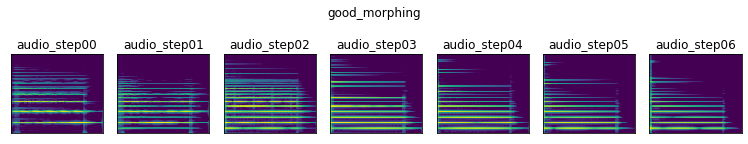

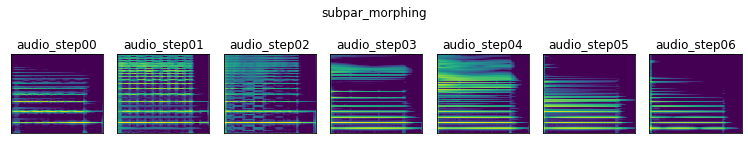

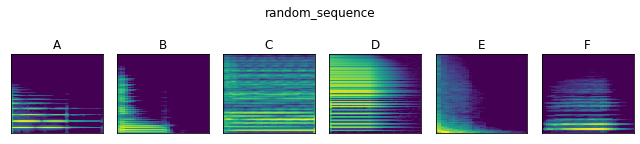

In [2]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile

for audio_files_single_morph in audio_files:
    fig, axes = plt.subplots(1, len(audio_files_single_morph), figsize=(len(audio_files_single_morph) * 1.5, 2.0))
    for audio_file, ax in zip(audio_files_single_morph, axes):
        audio, sr = soundfile.read(audio_file)
        if len(audio.shape) > 1:
            audio = librosa.to_mono(audio.T)
        s = librosa.feature.melspectrogram(y=audio, sr=sr)
        librosa.display.specshow(librosa.power_to_db(s), ax=ax, cmap='viridis')
        ax.set(title=audio_file.stem)
    fig.suptitle(audio_files_single_morph[0].parent.name)
    fig.tight_layout()

These Mel-Spectrograms seem to indicate that the first sequence is a good morphing, whose harmonic structure nicely changes throughout the sequence, while the second sequence seems quite worse.
The third sequence is made of random samples from different instruments (e.g. drums, piano, ...) thus can be considered as a very bad morphing.

This can be confirmed by listening to the 3 morphings.
Please note that audio cannot be played from Github and requires you to run this notebook on your machine.

In [ ]:
import IPython.display

def display_morph_audio(_audio_files):
    print(_audio_files[0].parent.name)
    for audio_file in _audio_files:
        audio, sr = soundfile.read(audio_file)
        display(IPython.display.Audio(audio.T, rate=sr))

display_morph_audio(audio_files[0])

In [ ]:
display_morph_audio(audio_files[1])

In [ ]:
display_morph_audio(audio_files[2])

---

# 2. Morphing Metrics (Python only)

In order to compute the metrics of a given morphed sequence, the ```soundmm.metrics.compute_metrics``` method first computes audio features for each individual audio sample from the sequence.
Then, the *non-smoothness* and *non-linearity* of each audio feature can be computed and are displayed on the figures below.
The best morphings will present the lowest *non-smoothness* and *non-linearity* values.

Two sets of audio features are available:
- [AudioCommons Timbral Models](https://github.com/AudioCommons/timbral_models) features, which only require the Python code from repository
- [Timbre Toolbox](https://github.com/VincentPerreault0/timbretoolbox) features, which require a local Matlab install and the toolbox to be compiled

This first example only uses AudioCommons Timbral Models (```ac_``` prefix) features.

All provided morphings will be analyzed using a single function call.
This allows a faster batch processing.

In [6]:
%%time

import sys
sys.path.append("../")

from src import soundmm

morphing_metrics, timbre_features = soundmm.metrics.compute_metrics(
    morphing_directories, 
    normalize=True,
    verbose=True
)

Computing AudioCommons Timbral Models features...
TimbreToolbox path was not provided, so the corresponding audio features won't be computed
CPU times: user 4min 11s, sys: 6.74 s, total: 4min 18s
Wall time: 14.1 s


## Morphing Metrics DataFrame

The most important result is the ```morphing_metrics``` Pandas DataFrame, which is displayed below.

In [7]:
audio_features_names = [c for c in morphing_metrics.columns if (c.startswith('ac_') or c.startswith('tt_'))]
morphing_metrics

,morphing_index,morphing_name,morphing_dir,metric,ac_hardness,ac_depth,ac_brightness,ac_roughness,ac_warmth,ac_sharpness,ac_boominess
0,0,good_morphing,data/good_morphing,nonsmoothness,0.441332,0.197479,0.189631,0.693868,0.112743,0.151382,0.178371
1,0,good_morphing,data/good_morphing,nonlinearity,0.118331,0.236184,0.262353,0.498313,0.085918,0.079545,0.149673
2,1,subpar_morphing,data/subpar_morphing,nonsmoothness,0.991938,0.827183,1.356754,1.245100,1.510961,1.777540,1.139953
3,1,subpar_morphing,data/subpar_morphing,nonlinearity,0.536025,0.669755,0.987541,1.150110,1.104341,1.210042,1.170009
4,2,random_sequence,data/random_sequence,nonsmoothness,1.566730,1.975338,1.453615,1.061032,1.376296,1.071077,1.681675
5,2,random_sequence,data/random_sequence,nonlinearity,2.345644,2.094061,1.750106,1.351578,1.809740,1.710413,1.680317


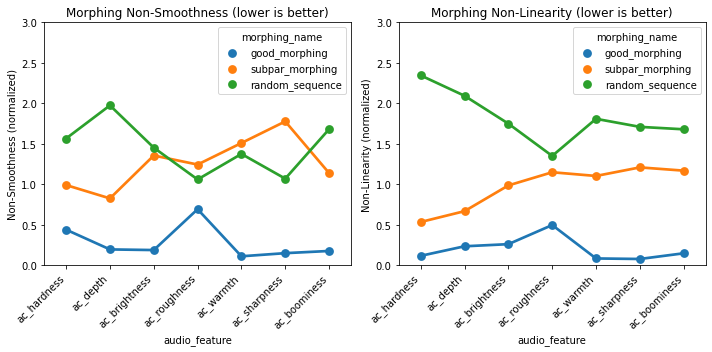

In [8]:
import pandas as pd
import seaborn as sns

morphing_metrics_long_form = pd.melt(
    morphing_metrics, id_vars=['morphing_name', 'metric'], value_vars=audio_features_names, var_name='audio_feature'
)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, metric_name) in enumerate(zip(axes, ['nonsmoothness', 'nonlinearity'])):
    sns.pointplot(
        data=morphing_metrics_long_form[morphing_metrics_long_form.metric == metric_name],
        x='audio_feature', y='value', hue='morphing_name', ax=ax,
    )
    metric_name = metric_name.replace('non', 'non-').title()
    ax.set(title=f'Morphing {metric_name} (lower is better)', ylabel=(metric_name + " (normalized)"))
    ax.set_ylim([0.0, 3.0])
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    #plt.xticks(rotation=45, ha='right')
fig.tight_layout()

## Audio Features Values

The morphing metrics are computed from normalized audio timbre features, which are also returned by the metric computation function.
Normalization constants can be modified directly in the ```soundmm.timbrefeatures``` module.

Features' values corresponding to each audio file are available in the ```timbre_features``` DataFrame.

In [9]:
pd.set_option('display.max_rows', 8)
timbre_features

,morphing_index,morphing_name,morphing_dir,audio_index,audio_file,ac_hardness,ac_depth,ac_brightness,ac_roughness,ac_warmth,ac_sharpness,ac_boominess
0,0,good_morphing,data/good_morphing,0,data/good_morphing/audio_step00.wav,-0.883608,-1.830589,0.235129,-1.830619,-0.545081,-0.287259,-1.234762
1,0,good_morphing,data/good_morphing,1,data/good_morphing/audio_step01.wav,-0.862235,-1.517125,0.129582,-0.346631,-0.447830,-0.291409,-1.219319
2,0,good_morphing,data/good_morphing,2,data/good_morphing/audio_step02.wav,-0.476811,-0.856981,0.333473,0.001761,-0.192145,-0.215875,-0.789725
3,0,good_morphing,data/good_morphing,3,data/good_morphing/audio_step03.wav,-0.134128,-0.539944,0.304241,-0.764727,0.067980,-0.325488,-0.574620
...,...,...,...,...,...,...,...,...,...,...,...,...
2,2,random_sequence,data/random_sequence,2,data/random_sequence/C.wav,0.502229,-0.656413,0.517384,1.410845,-0.209945,0.711524,-0.072745
3,2,random_sequence,data/random_sequence,3,data/random_sequence/D.wav,2.084721,-1.947907,1.988706,2.168159,-2.187101,2.269662,-1.691461
4,2,random_sequence,data/random_sequence,4,data/random_sequence/E.wav,0.343562,1.254503,-1.085480,-0.382932,0.138803,0.383229,1.606569
5,2,random_sequence,data/random_sequence,5,data/random_sequence/F.wav,-3.023928,0.333403,-1.332004,-2.022477,1.089689,-1.062514,0.969807


---
# 3. Full set of audio features (requires Matlab and Timbre Toolbox)

If Matlab is available locally and if Timbre Toolbox has been properly setup (see instructions on their Github repository), then the morphing metrics can be computed on the whole set of audio features.
Results for the same three morphings are displayed below.

In [10]:
%%time

morphing_metrics, timbre_features = soundmm.metrics.compute_metrics(
    morphing_directories, 
    timbre_toolbox_path='~/Documents/MATLAB/timbretoolbox',
    normalize=True,
    verbose=True
)

Computing AudioCommons Timbral Models features...
[#0]============ Launching matlab commands (will block if a Matlab error happens) ============
2023/11/28, 09:14:57
Subprocess args: ['matlab', '-nodisplay', '-nodesktop', '-nosplash', '-r', "addpath(genpath('~/Documents/MATLAB/timbretoolbox')); cd '/home/gwendal/Jupyter/sound-morphing-metrics/examples/../src/soundmm'; tt_features('/tmp/tmplhwucash'); exit "]

[MATLAB #0] 
[MATLAB #0]                             < M A T L A B (R) >
[MATLAB #0]                   Copyright 1984-2018 The MathWorks, Inc.
[MATLAB #0]                    R2018a (9.4.0.813654) 64-bit (glnxa64)
[MATLAB #0]                              February 23, 2018
[MATLAB #0] 
[MATLAB #0] 
[MATLAB #0] To get started, type one of these: helpwin, helpdesk, or demo.
[MATLAB #0] For product information, visit www.mathworks.com.
[MATLAB #0] 
[MATLAB #0] Script starts:23/11/28-09:14:59
[MATLAB #0] Input args file:
[MATLAB #0] /tmp/tmplhwucash
[MATLAB #0] Warning: Sound deemed not

In [11]:
audio_features_names = [c for c in morphing_metrics.columns if (c.startswith('ac_') or c.startswith('tt_'))]
morphing_metrics

,morphing_index,morphing_name,morphing_dir,metric,ac_hardness,ac_depth,ac_brightness,ac_roughness,ac_warmth,ac_sharpness,...,tt_AttSlope,tt_Dec,tt_DecSlope,tt_EffDur,tt_FreqMod,tt_LAT,tt_RMSEnv_med,tt_RMSEnv_IQR,tt_Rel,tt_TempCent
0,0,good_morphing,data/good_morphing,nonsmoothness,0.441332,0.197479,0.189631,0.693868,0.112743,0.151382,...,0.481435,0.298364,0.114077,0.349317,1.452527,0.202610,0.192704,0.810150,0.333571,0.197614
1,0,good_morphing,data/good_morphing,nonlinearity,0.118331,0.236184,0.262353,0.498313,0.085918,0.079545,...,0.610080,0.776263,0.278460,0.852713,1.263539,0.167184,0.249698,0.831663,0.804517,0.373011
2,1,subpar_morphing,data/subpar_morphing,nonsmoothness,0.991938,0.827183,1.356754,1.245100,1.510961,1.777540,...,0.487889,0.749818,0.189156,0.556027,0.372730,0.118922,0.435637,0.928473,0.527814,0.318262
3,1,subpar_morphing,data/subpar_morphing,nonlinearity,0.536025,0.669755,0.987541,1.150110,1.104341,1.210042,...,0.764891,0.966377,0.284113,0.959170,0.429887,0.195118,0.611809,1.226652,0.914522,0.400176
4,2,random_sequence,data/random_sequence,nonsmoothness,1.566730,1.975338,1.453615,1.061032,1.376296,1.071077,...,2.030676,1.951818,2.696767,2.094656,1.174743,2.678468,2.371659,1.261377,2.138615,2.484124
5,2,random_sequence,data/random_sequence,nonlinearity,2.345644,2.094061,1.750106,1.351578,1.809740,1.710413,...,1.625029,1.257360,2.437426,1.188117,1.306574,2.637698,2.138493,0.941685,1.280961,2.226813


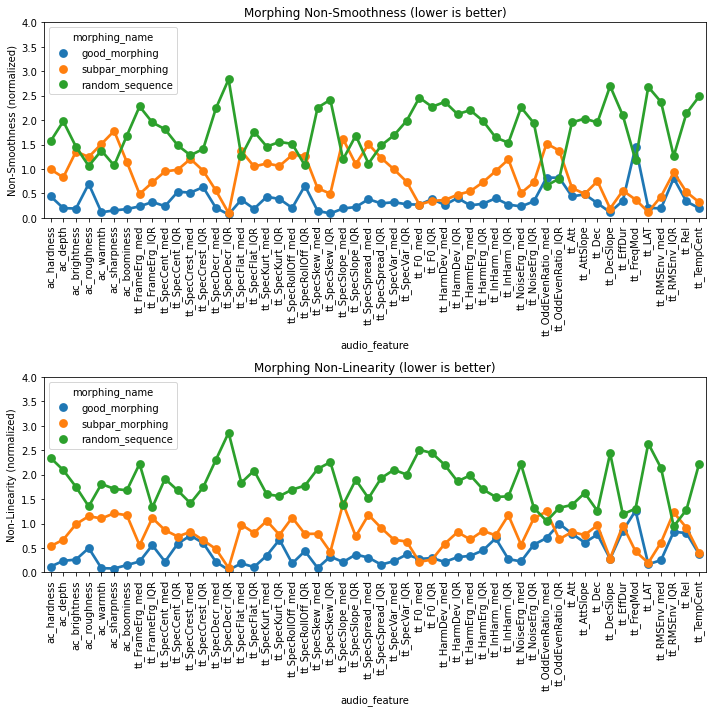

In [13]:
morphing_metrics_long_form = pd.melt(
    morphing_metrics, id_vars=['morphing_name', 'metric'], value_vars=audio_features_names, var_name='audio_feature'
)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for ax, metric_name in zip(axes, ['nonsmoothness', 'nonlinearity']):
    sns.pointplot(
        data=morphing_metrics_long_form[morphing_metrics_long_form.metric == metric_name],
        x='audio_feature', y='value', hue='morphing_name', ax=ax,
    )
    metric_name = metric_name.replace('non', 'non-').title()
    ax.set(title=f'Morphing {metric_name} (lower is better)', ylabel=(metric_name + " (normalized)"), ylim=[0.0, 4.0])
    ax.tick_params(axis='x', rotation=90)
fig.tight_layout()

---
# Citing

If you use our work, please cite the ICASSP 2023 paper:

```
@INPROCEEDINGS{10096397,
  author={Le Vaillant, Gwendal and Dutoit, Thierry},
  booktitle={ICASSP 2023 - 2023 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP)}, 
  title={Synthesizer Preset Interpolation Using Transformer Auto-Encoders}, 
  year={2023},
  pages={1-5},
  doi={10.1109/ICASSP49357.2023.10096397}
}
```